In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm import tqdm
import torch
import torchreid
device = torch.device("mps")

# Load pre-trained OSNet model
reid_model = torchreid.models.build_model(
    name='osnet_x1_0',
    num_classes=1000,
    pretrained=True)

reid_model = reid_model.to(device)
reid_model.eval()

model = YOLO("yolov8l.pt")

/Users/bogdanmatache/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/bogdanmatache/Library/Python/3.9/lib/python/site-packages/torchreid/reid/metrics/rank.py:11: UserWarning: Cython evaluation (very fast so highly recommended) is unavailable, now use python evaluation.
  warnings.warn(


Successfully loaded imagenet pretrained weights from "/Users/bogdanmatache/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"


In [2]:
def detect_people(frame):
    bboxes = {'bbox': [], 'frame': [], 'conf_score': []}
    result = model(frame, classes = [0], verbose = False)
    for conf_score in result[0].boxes.conf:
        bboxes['conf_score'].append(conf_score.squeeze().tolist())
    for bbox_coord in result[0].boxes.xyxy:
        bbox = (np.round(bbox_coord.squeeze().tolist()).astype(int)).tolist()
        bboxes['bbox'].append(bbox)
        bboxes['frame'].append(result[0].orig_img)
    return bboxes

In [3]:
def aggregate_features(features_list):
    aggregated_features = np.mean(features_list, axis=0)
    return aggregated_features

In [4]:
def cosine_similarity(a, b):
    a = a.flatten()
    b = b.flatten()
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def dot_product(a, b):
    a = a.flatten()
    b = b.flatten()
    return np.dot(a, b)

feature_db = {}
next_id = 0

def assign_id(features):
    global next_id
    best_match = None
    best_score = -1
    for id, db_features in feature_db.items():
        score = cosine_similarity(features.detach().cpu().numpy(), db_features)
        if score > best_score:
            best_score = score
            best_match = id
    if best_score > 0.65:  # threshold for matching
        return best_match
    else:
        feature_db[next_id] = features.detach().cpu().numpy()
        next_id += 1
        return next_id - 1

In [5]:
def preprocess(bbox, frame):
    image = frame[bbox[1]:bbox[3], bbox[0]:bbox[2]]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256, 256))
    image = image / 255.0
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std
    image = image.transpose(2, 0, 1)
    image = torch.FloatTensor(image)
    image = image.unsqueeze(0).to(device)
    return image

In [6]:
def extract_features(model, image):
    with torch.no_grad():
        features = model(image)
    return features

In [7]:
cap = cv2.VideoCapture('scene_example.avi')
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

out = cv2.VideoWriter('annotated_video_75_agg.avi', cv2.VideoWriter_fourcc(*'XVID'), frame_rate, (frame_width, frame_height))
inference_results = []

frame_data = {'frame_nr': [], 'bbox': [], 'id': [], 'orig_img': []}
feature_list = []
with tqdm(total=num_frames, desc="Person Detection") as pbar:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        id_list = []
        orig_img_list = []
        frame_nr_list = []
        bboxes_list = []

        frame_nr_list.append(int(cap.get(cv2.CAP_PROP_POS_FRAMES)))
        bboxes = detect_people(frame)
        for bbox, frame in zip(bboxes['bbox'], bboxes['frame']):
            image = preprocess(bbox, frame)
            features = reid_model(image)
            if int(cap.get(cv2.CAP_PROP_POS_FRAMES)) == 200 or int(cap.get(cv2.CAP_PROP_POS_FRAMES)) == 620:
                if len(feature_list) < 3:
                    feature_list.append(features)
            id = assign_id(features)
            id_list.append(id)
            orig_img_list.append(frame)
            bboxes_list.append(bbox)
            cv2.putText(frame, f"ID: {id}", (bbox[0], bbox[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
            frame_data['frame_nr'].append(frame_nr_list)
            frame_data['bbox'].append(bboxes_list)
            frame_data['id'].append(id_list)
            frame_data['orig_img'].append(orig_img_list)
        pbar.update(1)

        out.write(frame)

cap.release()
cv2.destroyAllWindows()

Person Detection: 100%|██████████| 718/718 [03:20<00:00,  3.58it/s]


In [8]:
import pandas as pd

frame_df = pd.DataFrame(frame_data)
frame_df.to_csv('frame_data_agg.csv')

In [9]:
"""for ids, bboxes, orig_img, frame_nr in zip(frame_data['id'], frame_data['bbox'], frame_data['orig_img'], frame_data['frame_nr']):
    for id in ids:
        print(f"ID: {id}")
        person_frame = orig_img[ids.index(id)]
        bbox_coord = bboxes[ids.index(id)]
        person_frame = person_frame[bbox_coord[1]:bbox_coord[3], bbox_coord[0]:bbox_coord[2]]
        plt.figure(figsize=(8, 6))
        plt.imshow(person_frame)
        plt.title(f"Person ID: {id} - Frame Number: {frame_nr}")
        plt.axis('off')
        plt.show()"""

'for ids, bboxes, orig_img, frame_nr in zip(frame_data[\'id\'], frame_data[\'bbox\'], frame_data[\'orig_img\'], frame_data[\'frame_nr\']):\n    for id in ids:\n        print(f"ID: {id}")\n        person_frame = orig_img[ids.index(id)]\n        bbox_coord = bboxes[ids.index(id)]\n        person_frame = person_frame[bbox_coord[1]:bbox_coord[3], bbox_coord[0]:bbox_coord[2]]\n        plt.figure(figsize=(8, 6))\n        plt.imshow(person_frame)\n        plt.title(f"Person ID: {id} - Frame Number: {frame_nr}")\n        plt.axis(\'off\')\n        plt.show()'

In [10]:
print(feature_list)

[tensor([[1.3658, 2.5424, 0.0000, 0.0000, 0.2329, 0.5956, 1.0382, 2.3106, 0.0000, 0.0000, 0.0000, 0.0000, 1.8967, 0.0000, 0.2649, 0.0000, 1.0763, 0.0000, 0.6883, 0.0000, 1.3817, 0.0000, 0.3413, 1.2020, 0.0000, 3.2018, 0.0000, 1.5927, 0.6510, 0.9483, 1.2381, 0.8031, 0.0000, 2.2280, 0.0000, 0.7380, 1.2344, 1.5845, 1.3473,
         1.4661, 0.0000, 0.1705, 0.6263, 0.0000, 0.0000, 0.0000, 1.1575, 2.6907, 0.3458, 0.0000, 0.0000, 0.6266, 0.0000, 2.5294, 1.8907, 1.7997, 0.7963, 2.4408, 0.0000, 0.0000, 0.0000, 0.1969, 1.2378, 0.6508, 0.6524, 0.7465, 2.4303, 0.1654, 0.0000, 0.0000, 0.8728, 0.0000, 0.0000, 0.5459, 0.4970, 0.0000, 0.0000, 1.1392,
         0.0000, 2.2869, 1.8096, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.1830, 0.3897, 0.0000, 0.6585, 1.0063, 2.0477, 0.5988, 0.0000, 0.0000, 0.0228, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1241, 2.5332, 0.8104, 1.4714, 0.0000, 0.6339, 0.3730, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         2.5378, 2.6620, 1.5124, 0.0

In [30]:
feature1, feature2 = feature_list[0], feature_list[1]

In [31]:
feature1 = feature1.detach().cpu().numpy().flatten()
feature2 = feature2.detach().cpu().numpy().flatten()

# Indices for trend line plotting
indices = np.arange(len(feature1))

# Trend line for x
slope_x, intercept_x = np.polyfit(indices, feature1, 1)
x_pred = slope_x * indices + intercept_x

# Trend line for y
slope_y, intercept_y = np.polyfit(indices, feature2, 1)
y_pred = slope_y * indices + intercept_y


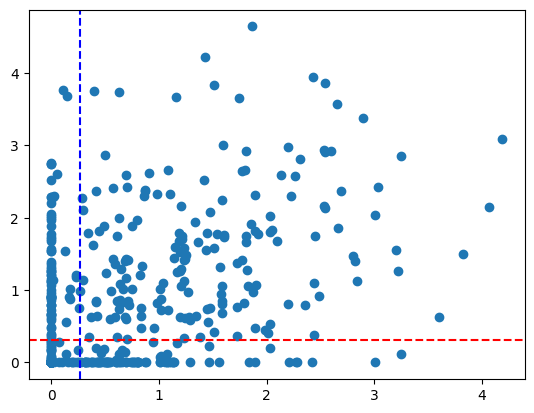

In [29]:
plt.scatter(feature1, feature2)
# Plot median line (horizontal and vertical)
plt.axhline(y=median1, color='r', linestyle='--', label='Median Y')
plt.axvline(x=median2, color='b', linestyle='--', label='Median X')


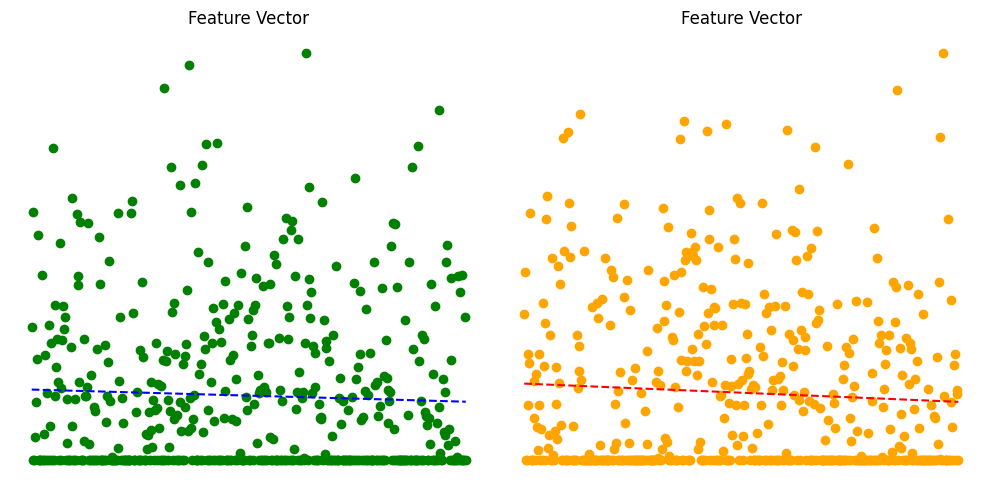

In [42]:
# Create a plot
plt.figure(figsize=(10, 5))

# Plot x with its trend line
plt.subplot(1, 2, 1)
plt.scatter(indices, feature1, color='green', label='x Data Points')
plt.plot(indices, x_pred, color='blue', linestyle='--', label='Trend Line for first photo')
plt.title('Feature Vector')
plt.xlabel('features_OX')
plt.ylabel('features_OY')
plt.axis('off')

# Plot y with its trend line
plt.subplot(1, 2, 2)
plt.scatter(indices, feature2, color='orange', label='y Data Points')
plt.plot(indices, y_pred, color='red', linestyle='--', label='Trend Line for second photo')
plt.title('Feature Vector')
plt.xlabel('features_OX')
plt.ylabel('features_OY')
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()


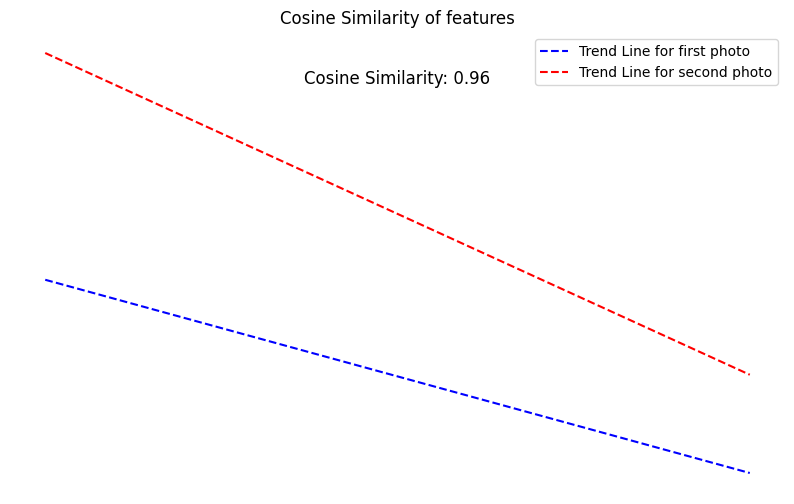

In [40]:
# Normalize the trend lines
x_pred_norm = (x_pred - np.mean(x_pred)) / np.linalg.norm(x_pred - np.mean(x_pred))
y_pred_norm = (y_pred - np.mean(y_pred)) / np.linalg.norm(y_pred - np.mean(y_pred))

# Calculate cosine similarity
cos_sim = np.dot(x_pred_norm, y_pred_norm) / (np.linalg.norm(x_pred_norm) * np.linalg.norm(y_pred_norm))

# Create a plot for trend lines and cosine similarity
plt.figure(figsize=(10, 6))

# Plot the trend line for x
plt.plot(indices, x_pred, color='blue', linestyle='--', label='Trend Line for first photo')

# Plot the trend line for y
plt.plot(indices, y_pred, color='red', linestyle='--', label='Trend Line for second photo')

# Add cosine similarity as a text annotation
plt.text(0.5, 0.9, f'Cosine Similarity: 0.96', fontsize=12, ha='center', va='center', transform=plt.gca().transAxes)

# Add titles and labels
plt.title('Cosine Similarity of features')
plt.axis('off')
plt.legend()

# Show the plot
plt.show()